#  Introduction to Machine Learning — 2024/2025 Evolutionary Algorithms

In [1]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import statistics


### Exercise 1


1. Build the simulation environment. Develop the following functionalities:
a) Create a function that produces a random bit pattern of a specific size (the bit pattern may be coded as a string of 0s and 1s)

In [2]:
def createRandIntPattern(length):
    stringWithIntPattern = ""
    for i in range(length):
        integer = random.randint(0,1)
        stringWithIntPattern += str(integer)

    return(stringWithIntPattern)

b) Create a function that will generate random patterns and measure how many attempts and how much time it takes to generate the “correct” bit pattern. 

Make two graphs on the evolution of attempts / time vs the number of bits in the pattern (2, 4, 8, 12, 16, ...). Each “point” in the graph should be a box-plot based on the results of 30 trials. 

Use a fixed set of seeds to be able to reproduce the experiments. 

In [3]:
def regenerateBitPattern(correctBitPattern):
    startTime = time.time()
    count = 0
    length = len(correctBitPattern)
    generatedBitPattern = createRandIntPattern(length)
    while generatedBitPattern != correctBitPattern:
        generatedBitPattern = createRandIntPattern(length)
        count += 1
    endTime = time.time()
    executionTime = endTime - startTime

    return (count, executionTime)


In [4]:
listNumberBits = [2, 4, 8, 10, 12, 14, 16]
listNumberBits = [2, 4, 8, 12, 16]

allBitesAllCounts = []
allBitesAllExecutionTimes = []
for numberBits in listNumberBits:
    random.seed(130)
    correctBitPattern = createRandIntPattern(numberBits)
    oneBiteAllCounts = []
    oneBiteAllExecutionTimes = []
    for i in range(30):
        count, executionTime = regenerateBitPattern(correctBitPattern)
        oneBiteAllCounts.append(count)
        oneBiteAllExecutionTimes.append(executionTime)
    allBitesAllCounts.append(oneBiteAllCounts)
    allBitesAllExecutionTimes.append(oneBiteAllExecutionTimes)



Mean number attempts:
3.0
15.0
246.0
3516.0
59254.0
Mean execution time:
0.0
0.0001
0.0016
0.031
0.696


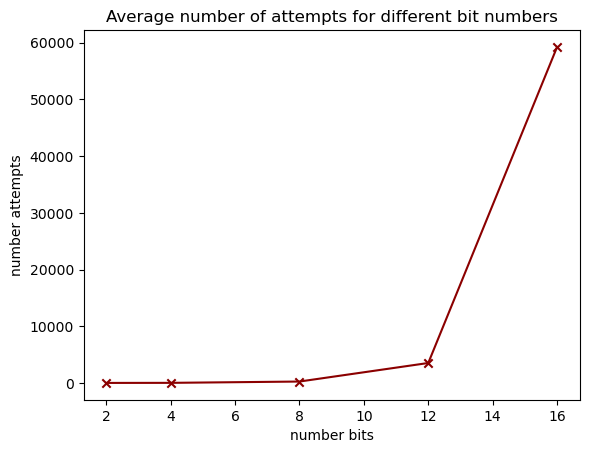

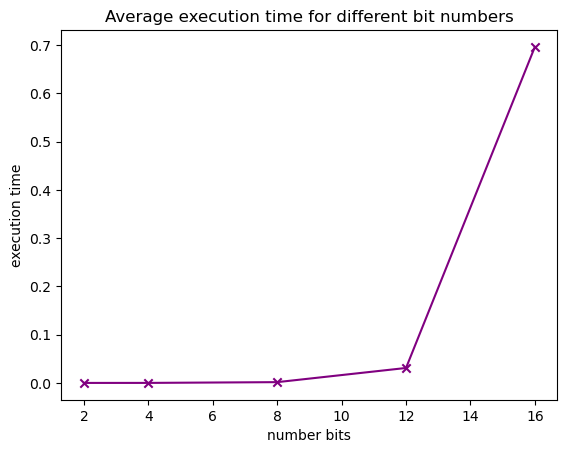

In [5]:
# give mean attempt number and execution time 
meansOfAttempts = []

print("Mean number attempts:")
for listWithItems in allBitesAllCounts:
    mean = statistics.mean(listWithItems)
    print(round(mean, 0))
    meansOfAttempts.append(mean)

meansOfExecutionTimes = []

print("Mean execution time:")
for listWithItems in allBitesAllExecutionTimes:
    mean = statistics.mean(listWithItems)
    print(round(mean, 4))
    meansOfExecutionTimes.append(mean)

# show in graph
plt.plot(listNumberBits, meansOfAttempts, c="darkred")
plt.scatter(listNumberBits, meansOfAttempts, c='darkred', marker='x')
plt.title('Average number of attempts for different bit numbers')
plt.xlabel("number bits")
plt.ylabel("number attempts")
plt.show()

plt.plot(listNumberBits, meansOfExecutionTimes, c="purple")
plt.scatter(listNumberBits, meansOfExecutionTimes, c='purple', marker='x')
plt.title('Average execution time for different bit numbers')
plt.xlabel("number bits")
plt.ylabel("execution time")
plt.show()

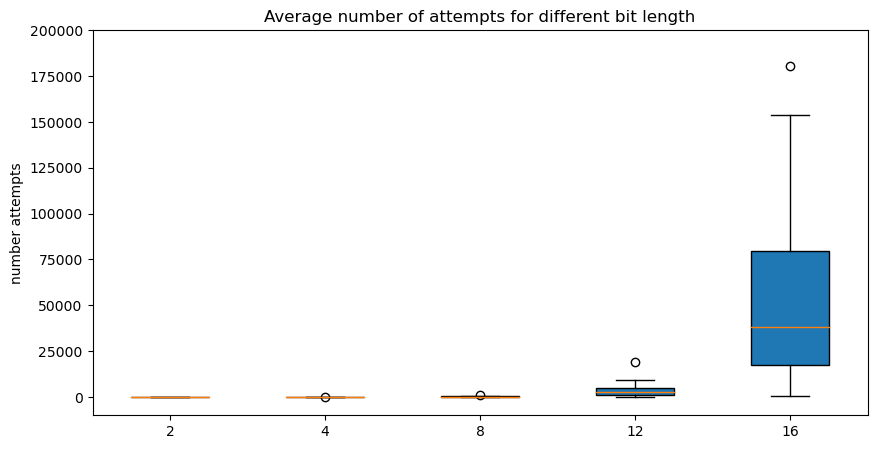

In [6]:
# visualise attempts
fig, ax = plt.subplots(figsize=(10,5))
ax.set_ylabel("number attempts")
ax.set_title('Average number of attempts for different bit length')
bplot = ax.boxplot(allBitesAllCounts, 
                labels = listNumberBits, 
                patch_artist=True,
                whis=1.5)
ax.set_ylim([-10000, 200000])

plt.show()

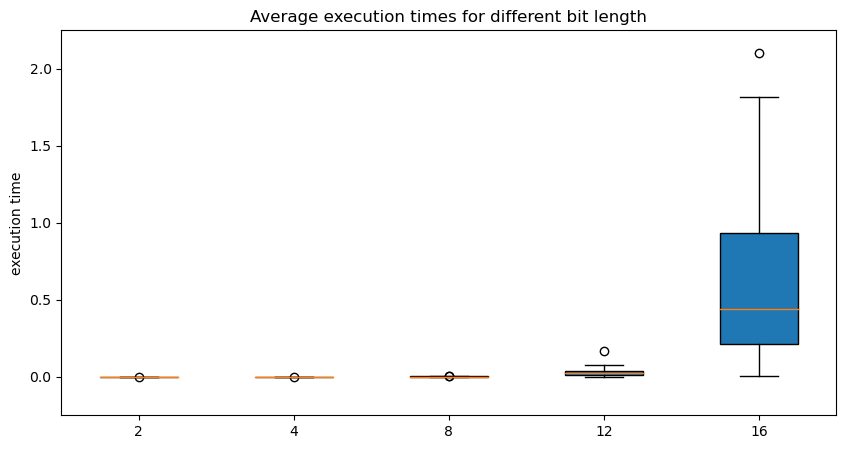

In [7]:
# visualise execution time
fig, ax = plt.subplots(figsize=(10,5))
ax.set_ylabel("execution time")
ax.set_title('Average execution times for different bit length')
bplot = ax.boxplot(allBitesAllExecutionTimes, 
                labels = listNumberBits, 
                patch_artist=True,
                whis=1.5)
ax.set_ylim([-0.25, 2.25])
plt.show()



c) Create a function that measures the “fitness” of the guessed pattern.This function should have a maximum value when the guessed pattern matches exactly the “correct” pattern and decreases as the distance between patterns increases.

In [8]:

def measureFitness(correctBitPattern, randomBitPattern):
    totalCorectBits = 0
    totalLengthBitPattern = len(correctBitPattern)
    for position in range(totalLengthBitPattern):
        if correctBitPattern[position] == randomBitPattern[position]:
            totalCorectBits += 1
    # normalise
    normalisedFitness = totalCorectBits/totalLengthBitPattern

    return(normalisedFitness)

# test function
randomBitPattern = createRandIntPattern(len(correctBitPattern))
measureFitness(correctBitPattern, randomBitPattern)

0.4375

d) Create a function to mutate (flip one bit) a given pattern. Use this function in a loop where the change is accepted only if it generates a better solution (i.e., a solution with higher fitness). Stop after 1000 mutations or when the pattern generated by mutation is equal to the solution. Does it always converge to the correct solution?

In [132]:
def mutateBit(correctBitPattern, randomBitPattern):
    totalLengthBitPattern = len(correctBitPattern)-1
    positionToMutate = random.randint(0, totalLengthBitPattern)
    randomBitPatternMutate = list(randomBitPattern)
    # mutate 
    if randomBitPatternMutate[positionToMutate] == "0":
        randomBitPatternMutate[positionToMutate] = "1"
    elif randomBitPatternMutate[positionToMutate] == "1":
        randomBitPatternMutate[positionToMutate] = "0"
    else:
        print("how possible, neither 0, nor 1")
    
    randomBitPatternMutate = "".join(randomBitPatternMutate)
    return(randomBitPatternMutate)

def acceptMutationIfBetterFitness(correctBitPattern, randomBitPattern):
    randomBitPatternMutate = mutateBit(correctBitPattern, randomBitPattern)
    # check if solution is better
    fitnessWithoutMutation = measureFitness(correctBitPattern, randomBitPattern)
    fitnessWithMutation = measureFitness(correctBitPattern, randomBitPatternMutate)
    if fitnessWithMutation >= fitnessWithoutMutation:
        randomBitPattern = randomBitPatternMutate
    
    return(randomBitPattern)

In [ ]:
lengthBitPattern = 16
correctBitPattern = createRandIntPattern(lengthBitPattern)
#print(f"Goal bit pattern: {correctBitPattern}")
randomBitPattern = createRandIntPattern(lengthBitPattern)

def getCorrectPatternWithMutations(correctBitPattern, randomBitPattern, maxNumberMutations = 1000):
    fitness = []
    count = 0
    while correctBitPattern != randomBitPattern and count < maxNumberMutations:
        fitness.append(measureFitness(correctBitPattern, randomBitPattern))
        randomBitPattern = acceptMutationIfBetterFitness(correctBitPattern, randomBitPattern)
        count += 1

    return(randomBitPattern, count, fitness)

# test function
randomBitPattern, count, fitness = getCorrectPatternWithMutations(correctBitPattern, randomBitPattern)
randomBitPattern

'1011001100011011'

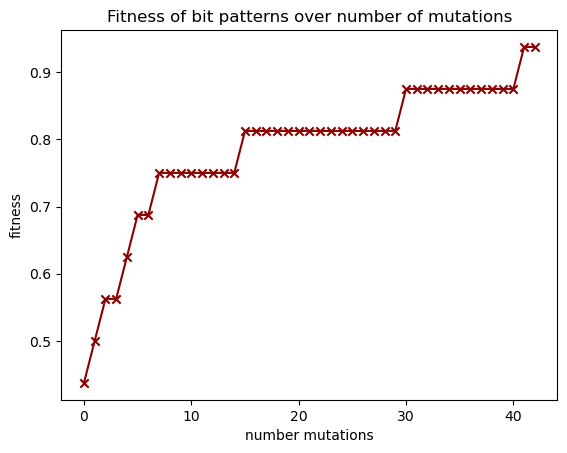

In [139]:
# visualise in graph
plt.plot(range(0, count), fitness, c="darkred")
plt.scatter(range(0, count), fitness, c='darkred', marker='x')
plt.title('Fitness of bit patterns over number of mutations')
plt.xlabel("number mutations")
plt.ylabel("fitness")
plt.show()
